In [1]:
%matplotlib inline
import os
import random
import cPickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

predicted web_site with probability 0.521
predicted comic_book with probability 0.162
predicted book_jacket with probability 0.055
predicted go-kart with probability 0.050
predicted tractor with probability 0.047


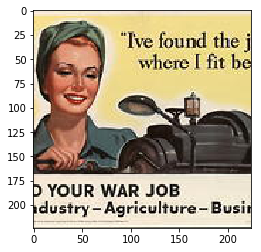

In [4]:
img, x = get_image("../images/scaled/0a219a4771fe880388022ef07092de91.jpg")
predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [29]:
type(feat[0])

numpy.ndarray

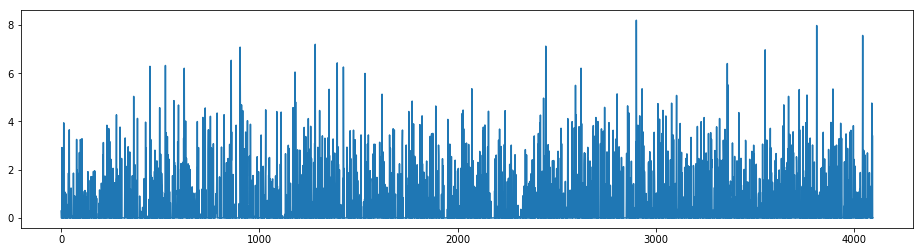

In [19]:
img, x = get_image("../images/scaled/0a219a4771fe880388022ef07092de91.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

In [27]:
feat[0]

array([0.2871237, 0.       , 0.       , ..., 3.4204621, 0.       ,
       0.       ], dtype=float32)

In [7]:
images_path = '../images/scaled'
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 2275 images to analyze


In [8]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

100%|██████████| 2275/2275 [20:40<00:00,  1.83it/s]


In [9]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [10]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5,1,'result images')

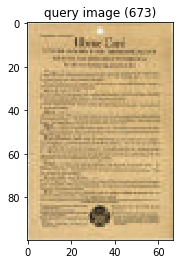

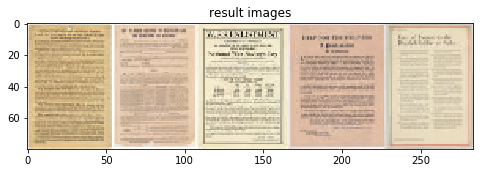

In [11]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 100)
results_image = get_concatenated_images(idx_closest, 80)

# display the query image
matplotlib.pyplot.figure(figsize = (4,4))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (8,6))
imshow(results_image)
matplotlib.pyplot.title("result images")

In [13]:
pickle.dump([images, pca_features], open('../output-ml4a/features_pca_base.p', 'wb'))

In [14]:
features = np.array(features)
pca2 = PCA(n_components=3)
pca2.fit(features)
pca_features2 = pca2.transform(features)

Text(0.5,1,'result images')

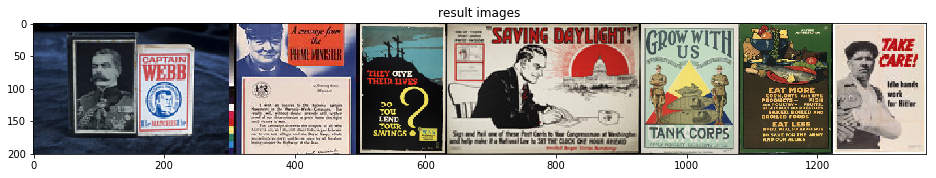

In [15]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops=4):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features2[query_image_idx_1] + (1.0-t) * pca_features2[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features2]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

# pick image and number of hops
num_hops = 6
query_image_idx_1 = int(len(images) * random.random())
query_image_idx_2 = int(len(images) * random.random())

# get path
path = get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops)

# draw image
path_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(path_image)
matplotlib.pyplot.title("result images")